# Soccer Analytics - Data Exploration Notebook

This notebook loads the StatsBomb Parquet extracts, inspects the main tables (matches, events, lineups, three-sixty, reference), and performs basic data-quality checks and small exploratory analyses. Use the sections below to navigate the notebook.

## Dataset Overview

StatsBomb football event data across five datasets: matches, events, lineups, reference, and three_sixty. Coverage spans 1958-2025 but heavily concentrated in 2015-2016.

## Dataset Characteristics

### Matches
- **3,464 matches** across 21 competitions
- **Temporal:** 54% concentrated in 2015-2016 (1,860 matches). Pre-2015: 425 scattered matches. Post-2016: 1,179 matches over 8 years.
- **Competitions:** La Liga 25%, Ligue 1 13%, Premier League 12%, Serie A 11%, Bundesliga 10%. Women's football 9.4%.
- **Outcomes:** 45.2% home wins, 23.0% draws, 31.8% away wins. 2.85 goals/match average.
- **Quality:** No duplicate IDs. Missing data limited to non-essential fields.

### Events
- **12,188,949 events** across 3,464 matches
- **Distribution:** Pass 27.8%, Ball Receipt 26.0%, Carry 21.6%, Pressure 9.1%, Shot 0.7%
- **Barcelona bias:** 10.2% of all events. Top 10 players all Barcelona 2010s (Messi, Busquets, Xavi, Iniesta).
- **Shot quality:** 9,383 total xG across 88,023 shots (0.107 avg). Only 8.1% qualify as big chances (xG > 0.3). Median 0.055 suggests many speculative efforts.
- **Passes:** 77.7% completion rate
- **Temporal:** 50.4% first half, 49.2% second half
- **Quality:** No duplicate IDs. 99.25% have location data. 20.9% under pressure.

### Lineups
- **165,820 entries** across 3,464 matches
- **Participation:** Only 32.5% actually played (53,883). Remaining 67.5% are unused squad listings.
- **Substitutions:** 6.2 avg per match. Starters 63.0 min avg, substitutes 13.4 min avg.
- **Playing time:** 2.1% played 90+ min, 39.2% played 60-90 min, 22.8% played 30-60 min, 25.2% under 15 min.
- **Cards:** 19,606 total (11.8%). 92.9% yellow. Busquets leads with 130.
- **Geography:** 141 countries. Spain 14.6%, France 9.1%, England 8.5%.
- **Quality:** 33,919 duplicate (match_id, player_id) pairs (20.4%), likely position changes not errors.

### Reference
- **9,566 rows** in 6 lookup tables
- **Tables:** country (141), event_type (35), play_pattern (9), player (9,043), position (26), team (312)
- All ID columns unique. Five duplicate player names, four duplicate team names (different entities, same name).
- Team table has gender info (male/female), only populated extra_info field.

### Three_Sixty
- **15,584,040 frames**
- **Coverage:** Only 9.3% of matches (323/3,464)
- **Competitions:** Tournament-focused. UEFA Euro 100%, Women's Euro 95%, but only 10% Bundesliga. No La Liga/PL/Serie A coverage.
- **Temporal:** All 2020-2025, zero overlap with dense 2015-2016 period.
- **Frames:** 50% teammate, 6.6% actor, 2.3% keeper. All have location + visible area polygons.

## Observations

### Dataset Imbalances
Barcelona represents 10% of events, top 10 players all 2010s Barcelona. Reflects 2015-2016 spike. Limits generalization beyond Barcelona/La Liga.

### Temporal Concentration
2015-2016 contains 54% of matches despite 2 years in 67-year span. Any "football" conclusions actually "mid-2010s European football" conclusions. Temporal imbalance severe enough to treat 2015-2016 as separate cohort.

### Data Completeness
Core events excellent (99.25% location, zero duplicates). Lineups problematic (67.5% non-participants). 360 limited (9.3% matches, zero overlap with dense period).

### Shot Quality
8.1% big chances (xG > 0.3), median 0.055. Either many low-probability shots or poor chance creation. Needs careful interpretation vs. league-wide benchmarks.

## Data Quality

**Strengths:**
- No duplicate IDs in matches/events
- 99%+ location coverage
- Complete timestamps
- 35 event types

**Limitations:**
- 54% temporal concentration
- Barcelona/La Liga bias
- 67.5% lineups are non-participants
- 9.3% 360 coverage
- Missing values in optional fields

## Analysis Considerations

The dataset characteristics suggest several points:

1. **Representativeness:** Barcelona/La Liga overweight means "football" conclusions actually weighted toward one team's 2010s style. Consider stratifying by competition or limiting scope explicitly.

2. **Temporal:** 2015-2016 dominates. Time-series models will struggle with sparse pre/post data.

3. **360 data:** 9.3% coverage, tournament-only, no overlap with dense period. Not suitable for systematic analysis. Case studies only.

4. **Lineups:** 67.5% non-participants. Filter to actual playing time before use. 20.4% duplicates need investigation.

5. **xG patterns:** Median 0.055 suggests dataset-specific shooting patterns or selection bias. Comparisons to other providers may not align.

In [2]:
# Setup and imports
# This cell installs small deps (if needed), imports libraries and sets display options.
!pip install matplotlib && pip install -q pandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from pathlib import Path

# Suppress common warnings for cleaner notebook output
warnings.filterwarnings("ignore")

# Display options for notebooks
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Data directory
DATA_DIR = Path("..") / "data" / "Statsbomb"
print(f"DATA_DIR: {DATA_DIR}")
print('Files present:', sorted([p.name for p in DATA_DIR.iterdir() if p.is_file()]))

DATA_DIR: ../data/Statsbomb
Files present: ['events.parquet', 'lineups.parquet', 'matches.parquet', 'reference.parquet', 'statsbomb_schema.md', 'three_sixty.parquet']


In [3]:
# Matches: one row per match
matches_path = DATA_DIR / "matches.parquet"
if not matches_path.exists():
    raise FileNotFoundError(f"Missing {matches_path}. Make sure data is downloaded into data/Statsbomb")

matches = pd.read_parquet(matches_path)
# Show a compact preview to confirm successful load
print('Matches shape:', matches.shape)
matches.head(3)

Matches shape: (3464, 36)


,match_id,match_date,match_week,match_status,match_status_360,kickoff,home_score,away_score,competition_id,competition,competition_stage,season_id,season,home_team_id,home_team,home_managers,away_team_id,away_team,away_managers,stadium_id,stadium,referee_id,referee,last_updated,last_updated_360,data_version,shot_fidelity_version,xy_fidelity_version,competition_name,gender,is_youth,is_international,country_name,season_name,match_updated,match_available_360
0,9880,2018-04-14,32,available,scheduled,16:15:00,2,1,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",207,Valencia,"[{""id"":211,""name"":""Marcelino García Toral"",""ni...",342.0,Spotify Camp Nou,2728.0,Carlos del Cerro Grande,2023-02-08T17:23:53.901920,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None
1,9912,2018-04-29,35,available,scheduled,20:45:00,2,4,11,La Liga,Regular Season,1,2017/2018,219,RC Deportivo La Coruña,"[{""id"":371,""name"":""Clarence Seedorf"",""nickname...",217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",4658.0,Estadio Abanca-Riazor,2602.0,Ricardo De Burgos Bengoetxea,2022-12-05T14:42:44.641092,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None
2,9924,2018-05-06,36,available,scheduled,20:45:00,2,2,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",220,Real Madrid,"[{""id"":56,""name"":""Zinédine Zidane"",""nickname"":...",342.0,Spotify Camp Nou,2608.0,Alejandro José Hernández Hernández,2022-12-01T03:25:12.063586,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,None


In [4]:
# --- Matches EDA ---
print('\n' + '='*80)
print('MATCHES DATASET')
print('='*80)

n_matches = len(matches)
print(f'\nTotal matches: {n_matches:,}')

# Dates
matches['match_date'] = pd.to_datetime(matches['match_date'], errors='coerce')
min_date = matches['match_date'].min()
max_date = matches['match_date'].max()
date_span = (max_date - min_date).days

print(f'Date range: {min_date.date()} to {max_date.date()} ({date_span:,} days)')

# Year distribution
matches['year'] = matches['match_date'].dt.year
print('\nMatches by year:')
for yr, cnt in matches['year'].value_counts().sort_index().items():
    print(f'  {yr}: {cnt:4d}')

# Day of week
matches['day_of_week'] = matches['match_date'].dt.day_name()
print('\nDay of week distribution:')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    cnt = (matches['day_of_week'] == day).sum()
    pct = cnt/n_matches*100
    print(f'  {day:9s}: {cnt:4d} ({pct:5.2f}%)')

# Competitions
print('\n--- Competitions ---')
comp_counts = matches['competition_name'].value_counts()
print(f'Total: {len(comp_counts)} competitions\n')
print('Top 10:')
for i, (comp, cnt) in enumerate(comp_counts.head(10).items(), 1):
    pct = cnt/n_matches*100
    print(f'{i:2d}. {comp:35s} {cnt:4d} ({pct:4.1f}%)')

# Seasons per competition
print('\nSeasons covered (top 5 competitions):')
comp_season = matches.groupby(['competition_name', 'season_name']).size().reset_index(name='matches')
for comp in comp_counts.head(5).index:
    comp_data = comp_season[comp_season['competition_name'] == comp]
    n_seasons = len(comp_data)
    avg = comp_data['matches'].mean()
    print(f'  {comp}: {n_seasons} seasons (avg {avg:.0f} matches/season)')

# Teams
all_teams = pd.concat([matches['home_team'], matches['away_team']])
team_counts = all_teams.value_counts()

print(f'\n--- Teams ---')
print(f'Unique teams: {len(team_counts)}')
print(f'Most frequent: {team_counts.index[0]} ({team_counts.iloc[0]} matches)')

# Match outcomes
print('\n--- Match Results ---')
home_wins = (matches['home_score'] > matches['away_score']).sum()
draws = (matches['home_score'] == matches['away_score']).sum()
away_wins = (matches['away_score'] > matches['home_score']).sum()

print(f'Home wins: {home_wins:4d} ({home_wins/n_matches*100:5.2f}%)')
print(f'Draws:     {draws:4d} ({draws/n_matches*100:5.2f}%)')
print(f'Away wins: {away_wins:4d} ({away_wins/n_matches*100:5.2f}%)')

# Goals
total_goals = matches['home_score'].sum() + matches['away_score'].sum()
print(f'\nTotal goals: {total_goals:.0f}')
print(f'Average per match: {total_goals/n_matches:.2f}')
print(f'  Home: {matches["home_score"].mean():.2f}')
print(f'  Away: {matches["away_score"].mean():.2f}')

# Common scorelines
matches['scoreline'] = matches['home_score'].astype(int).astype(str) + '-' + matches['away_score'].astype(int).astype(str)
print('\nMost common scorelines:')
for i, (score, cnt) in enumerate(matches['scoreline'].value_counts().head(10).items(), 1):
    pct = cnt/n_matches*100
    print(f'{i:2d}. {score:5s} {cnt:4d} ({pct:5.2f}%)')

# High/low scoring
matches['total_goals'] = matches['home_score'] + matches['away_score']
high_scoring = (matches['total_goals'] >= 6).sum()
goalless = (matches['total_goals'] == 0).sum()

print(f'\nHigh-scoring (6+ goals): {high_scoring} ({high_scoring/n_matches*100:.1f}%)')
print(f'Goalless (0-0): {goalless} ({goalless/n_matches*100:.1f}%)')

# Goal difference distribution
print('\nGoal difference (home - away):')
matches['goal_diff'] = matches['home_score'] - matches['away_score']
for gd in range(-5, 6):
    cnt = (matches['goal_diff'] == gd).sum()
    if cnt > 0:
        pct = cnt/n_matches*100
        bar = '█' * int(pct/2)
        print(f'  {gd:+2d}: {cnt:4d} ({pct:4.1f}%) {bar}')

# Data quality
print('\n--- Data Quality ---')
missing = matches.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if missing.empty:
    print('No missing values')
else:
    print('Missing values (top 10):')
    for col, cnt in missing.head(10).items():
        pct = cnt/len(matches)*100
        print(f'  {col:35s} {cnt:5,} ({pct:4.1f}%)')

# Duplicates
dup_ids = matches['match_id'].duplicated().sum()
print(f'\nDuplicate match_ids: {dup_ids}')

# Check for weird scores
max_score = max(matches['home_score'].max(), matches['away_score'].max())
if max_score > 10:
    print(f'\nNote: Highest score in dataset is {max_score:.0f}')
    extreme = matches[(matches['home_score'] > 10) | (matches['away_score'] > 10)]
    if len(extreme) > 0:
        print(f'Found {len(extreme)} matches with 10+ goals for one team')

print('\n' + '='*80)


MATCHES DATASET

Total matches: 3,464
Date range: 1958-06-24 to 2025-07-27 (24,505 days)

Matches by year:
  1958:    2
  1962:    1
  1970:    6
  1971:    1
  1972:    1
  1973:    1
  1974:    7
  1977:    1
  1978:    1
  1979:    1
  1981:    1
  1983:    1
  1984:    1
  1986:    4
  1989:    3
  1990:    1
  1997:    1
  1999:    1
  2003:   19
  2004:   25
  2005:   13
  2006:   16
  2007:   33
  2008:   27
  2009:   31
  2010:   37
  2011:   36
  2012:   39
  2013:   27
  2014:   37
  2015:  893
  2016:  967
  2017:   39
  2018:  194
  2019:  190
  2020:  120
  2021:  204
  2022:  193
  2023:  105
  2024:  153
  2025:   31

Day of week distribution:
  Monday   :  163 ( 4.71%)
  Tuesday  :  163 ( 4.71%)
  Wednesday:  296 ( 8.55%)
  Thursday :  102 ( 2.94%)
  Friday   :  188 ( 5.43%)
  Saturday : 1307 (37.73%)
  Sunday   : 1245 (35.94%)

--- Competitions ---
Total: 21 competitions

Top 10:
 1. La Liga                              868 (25.1%)
 2. Ligue 1                         

In [6]:
# Events: one row per event per match 
events_path = DATA_DIR / "events.parquet"
if not events_path.exists():
    raise FileNotFoundError(f"Missing {events_path}. Make sure data is downloaded into data/Statsbomb")

events = pd.read_parquet(events_path)
# Show a compact preview to confirm successful load
print('Events shape:', events.shape)
events.head(3)

Events shape: (12188949, 112)


,id,index_num,period,minute,second,timestamp,duration,location_x,location_y,possession,possession_team_id,possession_team,out,off_camera,counterpress,under_pressure,type_id,type,match_id,team_id,team,player_id,player,position_id,position,play_pattern_id,play_pattern,shot_end_location_x,shot_end_location_y,shot_end_location_z,shot_statsbomb_xg,shot_outcome,shot_technique,shot_body_part,shot_type,shot_key_pass_id,shot_freeze_frame,shot_first_time,shot_deflected,shot_aerial_won,shot_follows_dribble,shot_one_on_one,shot_open_goal,shot_redirect,shot_saved_off_target,shot_saved_to_post,pass_end_location_x,pass_end_location_y,pass_recipient_id,pass_recipient,pass_length,pass_angle,pass_height,pass_body_part,pass_type,pass_outcome,pass_technique,pass_assisted_shot_id,pass_goal_assist,pass_shot_assist,pass_cross,pass_switch,pass_through_ball,pass_aerial_won,pass_deflected,pass_inswinging,pass_outswinging,pass_no_touch,pass_cut_back,pass_straight,pass_miscommunication,carry_end_location_x,carry_end_location_y,dribble_outcome,dribble_nutmeg,dribble_overrun,dribble_no_touch,duel_type,duel_outcome,foul_committed_card,foul_committed_type,foul_committed_offensive,foul_committed_advantage,foul_committed_penalty,foul_won_defensive,foul_won_advantage,foul_won_penalty,goalkeeper_type,goalkeeper_outcome,goalkeeper_technique,goalkeeper_position,goalkeeper_body_part,goalkeeper_end_location_x,goalkeeper_end_location_y,clearance_body_part,clearance_aerial_won,clearance_head,clearance_left_foot,clearance_right_foot,interception_outcome,block_deflection,block_offensive,block_save_block,ball_recovery_offensive,ball_recovery_failure,miscontrol_aerial_won,substitution_replacement_id,substitution_replacement_name,substitution_outcome,fifty_fifty_outcome,bad_behaviour_card,injury_stoppage_in_chain
0,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,1,1,0,0,00:00:00,0.0,NaN,NaN,1,217,Barcelona,False,False,False,False,35,Starting XI,15946,217,Barcelona,NaN,None,NaN,None,1,Regular Play,NaN,NaN,NaN,NaN,None,None,None,None,None,None,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,None,False,False,False,None,None,None,None,False,False,False,False,False,False,None,None,None,None,None,NaN,NaN,None,False,False,False,False,None,False,False,False,False,False,False,NaN,None,None,None,None,False
1,0300039d-150d-41e4-b29a-76602ef002e6,2,1,0,0,00:00:00,0.0,NaN,NaN,1,217,Barcelona,False,False,False,False,35,Starting XI,15946,206,Deportivo Alavés,NaN,None,NaN,None,1,Regular Play,NaN,NaN,NaN,NaN,None,None,None,None,None,None,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,None,False,False,False,None,None,None,None,False,False,False,False,False,False,None,None,None,None,None,NaN,NaN,None,False,False,False,False,None,False,False,False,False,False,False,NaN,None,None,None,None,False
2,491e8901-7630-4cc8-b57b-937dddff2eaa,3,1,0,0,00:00:00,0.0,NaN,NaN,1,217,Barcelona,False,False,False,False,18,Half Start,15946,217,Barcelona,NaN,None,NaN,None,1,Regular Play,NaN,NaN,NaN,NaN,None,None,None,None,None,None,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,None,False,False,False,None,None,None,None,False,False,False,False,False,False,None,None,None,None,None,NaN,NaN,None,False,False,False,False,None,False,False,False,False,False,False,NaN,None,None,None,None,False


In [7]:
# --- Events EDA ---
print('\n' + '='*80)
print('EVENTS DATASET')
print('='*80)

n_events = len(events)
n_matches = events['match_id'].nunique()

print(f'\nTotal events: {n_events:,}')
print(f'Unique matches: {n_matches:,}')
print(f'Events per match: {n_events/n_matches:.0f} avg')

# Events per match distribution
events_per_match = events.groupby('match_id').size()
print(f'\nDistribution:')
print(f'  Min: {events_per_match.min():,}')
print(f'  Median: {events_per_match.median():,.0f}')
print(f'  Max: {events_per_match.max():,}')

# Check for outliers
low_threshold = events_per_match.quantile(0.05)
low_matches = events_per_match[events_per_match < low_threshold]
if len(low_matches) > 0:
    print(f'\nNote: {len(low_matches)} matches have <{low_threshold:.0f} events (bottom 5%)')

# Event types
print('\n--- Event Types ---')
event_types = events['type'].value_counts()
print(f'Total types: {len(event_types)}\n')
print('Top 15:')
for i, (etype, cnt) in enumerate(event_types.head(15).items(), 1):
    pct = cnt/n_events*100
    bar = '█' * int(pct/5)
    print(f'{i:2d}. {etype:20s} {cnt:8,} ({pct:5.2f}%) {bar}')

# Teams and players
print('\n--- Teams & Players ---')
print(f'Unique teams: {events["team"].nunique()}')
print(f'Unique players: {events["player"].nunique()}')

print('\nMost active teams:')
for i, (team, cnt) in enumerate(events['team'].value_counts().head(10).items(), 1):
    print(f'{i:2d}. {team:25s} {cnt:8,}')

print('\nMost active players:')
for i, (player, cnt) in enumerate(events['player'].value_counts().head(10).items(), 1):
    print(f'{i:2d}. {player:30s} {cnt:6,}')

# Events without player
no_player = events['player'].isna().sum()
print(f'\nEvents without player: {no_player:,} ({no_player/n_events*100:.2f}%)')

# Temporal
print('\n--- Temporal ---')
if 'period' in events.columns:
    print('By period:')
    for period, cnt in events['period'].value_counts().sort_index().items():
        pct = cnt/n_events*100
        print(f'  Period {int(period)}: {cnt:8,} ({pct:5.2f}%)')

if 'minute' in events.columns:
    events['minute_bin'] = pd.cut(events['minute'], 
                                   bins=[0, 15, 30, 45, 60, 75, 90, 120],
                                   labels=['0-15', '16-30', '31-45', '46-60', '61-75', '76-90', '90+'])
    print('\nBy minute:')
    for bin_label, cnt in events['minute_bin'].value_counts().sort_index().items():
        pct = cnt/n_events*100
        print(f'  {bin_label:8s} {cnt:8,} ({pct:5.2f}%)')
    
    late = (events['minute'] > 90).sum()
    print(f'\nAfter 90min: {late:,} ({late/n_events*100:.2f}%)')

# Location
print('\n--- Location ---')
has_location = events[['location_x', 'location_y']].notna().all(axis=1).sum()
print(f'Events with location: {has_location:,} ({has_location/n_events*100:.2f}%)')

if has_location > 0:
    print(f'\nField dimensions:')
    print(f'  X: {events["location_x"].min():.1f} to {events["location_x"].max():.1f}')
    print(f'  Y: {events["location_y"].min():.1f} to {events["location_y"].max():.1f}')
    
    # Field zones
    events['zone'] = pd.cut(events['location_x'], 
                            bins=[0, 40, 80, 120],
                            labels=['Defensive', 'Middle', 'Attacking'])
    print('\nBy zone:')
    for zone, cnt in events['zone'].value_counts().items():
        pct = cnt/n_events*100
        print(f'  {zone:12s} {cnt:8,} ({pct:5.2f}%)')

# Shots
print('\n--- Shots ---')
shots = events[events['type'] == 'Shot']
print(f'Total shots: {len(shots):,}')

if len(shots) > 0 and 'shot_statsbomb_xg' in shots.columns:
    total_xg = shots['shot_statsbomb_xg'].sum()
    avg_xg = shots['shot_statsbomb_xg'].mean()
    
    print(f'Total xG: {total_xg:.1f}')
    print(f'Avg xG/shot: {avg_xg:.3f}')
    print(f'Median xG: {shots["shot_statsbomb_xg"].median():.3f}')
    
    # Quality breakdown
    high_quality = (shots['shot_statsbomb_xg'] > 0.3).sum()
    print(f'\nBig chances (xG>0.3): {high_quality:,} ({high_quality/len(shots)*100:.1f}%)')
    
    if 'shot_outcome' in shots.columns:
        print('\nOutcomes:')
        for outcome, cnt in shots['shot_outcome'].value_counts().items():
            pct = cnt/len(shots)*100
            print(f'  {outcome:15s} {cnt:5,} ({pct:5.2f}%)')

# Passes
print('\n--- Passes ---')
passes = events[events['type'] == 'Pass']
print(f'Total passes: {len(passes):,}')

if len(passes) > 0 and 'pass_outcome' in passes.columns:
    completed = passes['pass_outcome'].isna().sum()
    print(f'Completion: {completed:,}/{len(passes):,} ({completed/len(passes)*100:.1f}%)')
    
    # Incomplete reasons
    incomplete = passes['pass_outcome'].value_counts()
    if len(incomplete) > 0:
        print('\nIncomplete reasons:')
        for reason, cnt in incomplete.head(5).items():
            pct = cnt/len(passes)*100
            print(f'  {reason:20s} {cnt:5,} ({pct:4.1f}%)')

# Context flags
print('\n--- Context ---')
if 'under_pressure' in events.columns:
    pressure = events['under_pressure'].sum()
    print(f'Under pressure: {pressure:,} ({pressure/n_events*100:.1f}%)')

if 'counterpress' in events.columns:
    counterpress = events['counterpress'].sum()
    print(f'Counterpress: {counterpress:,} ({counterpress/n_events*100:.1f}%)')

# Play patterns
if 'play_pattern' in events.columns:
    print('\nPlay patterns:')
    for pattern, cnt in events['play_pattern'].value_counts().items():
        pct = cnt/n_events*100
        print(f'  {pattern:25s} {cnt:8,} ({pct:5.1f}%)')

# Data quality
print('\n--- Data Quality ---')
missing = events.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print(f'Columns with missing data: {len(missing)}/{len(events.columns)}')
print('\nTop 15:')
for col, cnt in missing.head(15).items():
    pct = cnt/len(events)*100
    print(f'  {col:35s} {cnt:10,} ({pct:5.1f}%)')

if 'id' in events.columns:
    dups = events['id'].duplicated().sum()
    print(f'\nDuplicate IDs: {dups}')

print('\n' + '='*80)


EVENTS DATASET

Total events: 12,188,949
Unique matches: 3,464
Events per match: 3519 avg

Distribution:
  Min: 2,101
  Median: 3,503
  Max: 5,190

Note: 173 matches have <2912 events (bottom 5%)

--- Event Types ---
Total types: 35

Top 15:
 1. Pass                 3,387,760 (27.79%) █████
 2. Ball Receipt*        3,167,310 (25.99%) █████
 3. Carry                2,632,570 (21.60%) ████
 4. Pressure             1,113,859 ( 9.14%) █
 5. Ball Recovery         366,673 ( 3.01%) 
 6. Duel                  257,861 ( 2.12%) 
 7. Clearance             158,993 ( 1.30%) 
 8. Block                 132,352 ( 1.09%) 
 9. Dribble               122,047 ( 1.00%) 
10. Goal Keeper           106,574 ( 0.87%) 
11. Foul Committed        100,510 ( 0.82%) 
12. Miscontrol             99,391 ( 0.82%) 
13. Foul Won               95,596 ( 0.78%) 
14. Dispossessed           88,814 ( 0.73%) 
15. Shot                   88,023 ( 0.72%) 

--- Teams & Players ---
Unique teams: 308
Unique players: 9038

Most active t

In [8]:
# Lineups: one row per player per match
lineups_path = DATA_DIR / "lineups.parquet"
if not lineups_path.exists():
    raise FileNotFoundError(f"Missing {lineups_path}. Make sure data is downloaded into data/Statsbomb")

lineups = pd.read_parquet(lineups_path)
# Show a compact preview to confirm successful load
print('Lineups shape:', lineups.shape)
lineups.head(3)

Lineups shape: (165820, 17)


,match_id,team_id,player_id,player_name,player_nickname,jersey_number,country_id,country_name,team_name,position_name,from_time,to_time,from_period,to_period,card_time,card_type,card_reason
0,15946,206,6839,Daniel Alejandro Torres Rojas,Dani Torres,16,49.0,Colombia,Deportivo Alavés,Center Defensive Midfield,00:00,67:48,1.0,2.0,09:15,Yellow Card,Foul Committed
1,15946,206,6855,Guillermo Alfonso Maripán Loaysa,Guillermo Maripán,6,45.0,Chile,Deportivo Alavés,Left Center Back,00:00,None,1.0,NaN,40:46,Yellow Card,Bad Behaviour
2,15956,217,5213,Gerard Piqué Bernabéu,Gerard Piqué,3,214.0,Spain,Barcelona,Right Center Back,00:00,None,1.0,NaN,59:01,Yellow Card,Foul Committed


In [9]:
# --- Lineups: Focused Deep EDA ---
print('\n' + '='*80)
print('DEEP DIVE: lineups')
print('='*80)

# Helper function for minutes calculation 
def calculate_minutes(from_time, to_time):
    """
    Calculate minutes played from time strings like '00:00' and '45:30'
    Returns minutes as integer, or None if invalid
    """
    try:
        if pd.isna(to_time) or pd.isna(from_time):
            return None
        
        # Handle string conversion
        from_time_str = str(from_time).strip()
        to_time_str = str(to_time).strip()
        
        # Parse from_time
        from_parts = from_time_str.split(':')
        if len(from_parts) < 2:
            return None
        from_mins = int(from_parts[0]) + int(from_parts[1]) / 60.0
        
        # Parse to_time
        to_parts = to_time_str.split(':')
        if len(to_parts) < 2:
            return None
        to_mins = int(to_parts[0]) + int(to_parts[1]) / 60.0
        
        # Calculate difference
        minutes = to_mins - from_mins
        
        # Sanity check: should be between 0 and 120 (including extra time)
        if minutes < 0 or minutes > 130:
            return None
            
        return minutes
    except:
        return None

# ============================================================================
# SECTION 1: KEY TAKEAWAYS - DATASET OVERVIEW
# ============================================================================
print('[1] DATASET OVERVIEW - KEY TAKEAWAYS')
print('-' * 80)

n_lineups = len(lineups)
n_unique_matches = lineups['match_id'].nunique()
n_unique_players = lineups['player_id'].nunique()
n_unique_teams = lineups['team_id'].nunique()

print(f'\n SCALE:')
print(f'  • Total lineup entries: {n_lineups:,}')
print(f'  • Unique matches: {n_unique_matches:,}')
print(f'  • Unique players: {n_unique_players:,}')
print(f'  • Unique teams: {n_unique_teams:,}')
print(f'  • Avg players per match: {n_lineups/n_unique_matches:.1f}')

# Expected: ~22-25 players per match (11 starters × 2 teams + subs)
expected_avg = 22
if n_lineups/n_unique_matches < expected_avg:
    print(f'\n WARNING: Average is low (expected ~{expected_avg}+)')
    print(f'  • May indicate missing substitutes or incomplete lineups')

# Players per match distribution
players_per_match = lineups.groupby('match_id').size()
print(f'\n PLAYERS PER MATCH:')
print(f'  • Min: {players_per_match.min()}')
print(f'  • Median: {players_per_match.median():.0f}')
print(f'  • Max: {players_per_match.max()}')

# Flag unusual matches
low_player_threshold = 20  # Less than typical starting XI × 2
high_player_threshold = 30  # More than normal with full benches

low_player_matches = players_per_match[players_per_match < low_player_threshold]
high_player_matches = players_per_match[players_per_match > high_player_threshold]

if len(low_player_matches) > 0:
    print(f'\n Matches with <{low_player_threshold} players: {len(low_player_matches)}')
    print(f'  • Could indicate incomplete data or red cards')

if len(high_player_matches) > 0:
    print(f'\n  Matches with >{high_player_threshold} players: {len(high_player_matches)}')
    print(f'  • Normal for matches with many substitutes')

# ============================================================================
# SECTION 2: PLAYER & TEAM ANALYSIS
# ============================================================================
print('\n\n[2] PLAYER & TEAM COVERAGE')
print('-' * 80)

# Most frequent players
player_appearances = lineups['player_name'].value_counts()
print(f'\nMost frequent players (appearances):')
for i, (player, count) in enumerate(player_appearances.head(10).items(), 1):
    print(f'{i:2d}. {player:40s}: {count:3d} matches')

# Most frequent teams
team_appearances = lineups['team_name'].value_counts()
print(f'\nMost frequent teams (lineup entries):')
for i, (team, count) in enumerate(team_appearances.head(10).items(), 1):
    avg_per_match = count / (lineups[lineups['team_name'] == team]['match_id'].nunique())
    print(f'{i:2d}. {team:30s}: {count:5,} entries ({avg_per_match:.1f} players/match)')

# Players per team
players_per_team = lineups.groupby('team_name')['player_id'].nunique().sort_values(ascending=False)
print(f'\nTeams using most unique players:')
for i, (team, count) in enumerate(players_per_team.head(10).items(), 1):
    print(f'{i:2d}. {team:30s}: {count:3d} unique players')

# ============================================================================
# SECTION 3: POSITION ANALYSIS
# ============================================================================
print('\n\n[3] POSITION DISTRIBUTION')
print('-' * 80)

if 'position_name' in lineups.columns:
    position_counts = lineups['position_name'].value_counts()
    print(f'\nTotal positions: {len(position_counts)}')
    print(f'\nTop 15 positions:')
    for i, (pos, count) in enumerate(position_counts.head(15).items(), 1):
        pct = count/n_lineups*100
        print(f'{i:2d}. {pos:30s}: {count:6,} ({pct:5.2f}%)')
    
    # Expected distribution check
    expected_positions = ['Goalkeeper', 'Center Back', 'Full Back', 'Defensive Midfield', 
                         'Center Midfield', 'Forward', 'Wing']
    missing_positions = [pos for pos in expected_positions 
                        if not any(pos.lower() in p.lower() for p in position_counts.index)]
    
    if missing_positions:
        print(f'\n Expected positions not found: {", ".join(missing_positions)}')
else:
    print('\n No position_name column found')

# ============================================================================
# SECTION 4: SUBSTITUTION & PLAYING TIME ANALYSIS
# ============================================================================
print('\n\n[4] SUBSTITUTIONS & PLAYING TIME')
print('-' * 80)

if 'from_time' in lineups.columns and 'to_time' in lineups.columns:
    # Calculate playing time first
    print('Calculating playing time...')
    lineups['minutes_played'] = lineups.apply(
        lambda row: calculate_minutes(row['from_time'], row['to_time']), 
        axis=1
    )
    
    # Categorize players
    starters = lineups[lineups['from_time'] == '00:00'].copy()
    non_starters = lineups[lineups['from_time'] != '00:00'].copy()
    
    # Among non-starters, separate actual subs from unused bench
    actual_subs = non_starters[non_starters['minutes_played'].notna() & (non_starters['minutes_played'] > 0)]
    unused_bench = non_starters[non_starters['minutes_played'].isna() | (non_starters['minutes_played'] == 0)]
    
    # Also check starters who might have 0 minutes (red card before kickoff, injury in warmup, etc.)
    starters_who_played = starters[starters['minutes_played'].notna() & (starters['minutes_played'] > 0)]
    starters_unused = starters[starters['minutes_played'].isna() | (starters['minutes_played'] == 0)]
    
    print(f'\n PLAYER CATEGORIES:')
    print(f'  • Starters (listed at 00:00): {len(starters):,} ({len(starters)/n_lineups*100:.1f}%)')
    print(f'    - Actually played: {len(starters_who_played):,}')
    print(f'    - Did not play: {len(starters_unused):,}')
    print(f'  • Non-starters: {len(non_starters):,} ({len(non_starters)/n_lineups*100:.1f}%)')
    print(f'    - Substitutes (came on): {len(actual_subs):,}')
    print(f'    - Unused bench: {len(unused_bench):,}')
    
    print(f'\n PLAYERS WHO ACTUALLY PLAYED:')
    total_played = len(starters_who_played) + len(actual_subs)
    print(f'  • Total: {total_played:,} ({total_played/n_lineups*100:.1f}% of all entries)')
    print(f'  • Starters: {len(starters_who_played):,} ({len(starters_who_played)/total_played*100:.1f}%)')
    print(f'  • Substitutes: {len(actual_subs):,} ({len(actual_subs)/total_played*100:.1f}%)')
    
    # Substitutions per match (only actual subs)
    actual_subs_per_match = actual_subs.groupby('match_id').size()
    print(f'\n ACTUAL SUBSTITUTIONS PER MATCH:')
    print(f'  • Average: {actual_subs_per_match.mean():.1f}')
    print(f'  • Median: {actual_subs_per_match.median():.0f}')
    print(f'  • Max: {actual_subs_per_match.max():.0f}')
    print(f'  • Matches with subs: {len(actual_subs_per_match):,}/{n_unique_matches:,}')
    
    # Unused bench per match
    unused_per_match = unused_bench.groupby('match_id').size()
    print(f'\n UNUSED BENCH PLAYERS PER MATCH:')
    print(f'  • Average: {unused_per_match.mean():.1f}')
    print(f'  • Median: {unused_per_match.median():.0f}')
    print(f'  • Max: {unused_per_match.max():.0f}')
    
    # Playing time analysis - only for players who actually played
    valid_minutes = lineups['minutes_played'].dropna()
    valid_minutes = valid_minutes[valid_minutes > 0]  # Exclude 0 minutes
    
    if len(valid_minutes) > 0:
        print(f'\n PLAYING TIME STATISTICS ({len(valid_minutes):,} players who played):')
        print(f'  • Average: {valid_minutes.mean():.1f} minutes')
        print(f'  • Median: {valid_minutes.median():.1f} minutes')
        print(f'  • Min: {valid_minutes.min():.1f} minutes')
        print(f'  • Max: {valid_minutes.max():.1f} minutes')
        
        # Distribution
        print(f'\n  Playing time distribution:')
        full_90 = (valid_minutes >= 90).sum()
        min_60_90 = ((valid_minutes >= 60) & (valid_minutes < 90)).sum()
        min_30_60 = ((valid_minutes >= 30) & (valid_minutes < 60)).sum()
        min_15_30 = ((valid_minutes >= 15) & (valid_minutes < 30)).sum()
        min_under_15 = (valid_minutes < 15).sum()
        
        print(f'    - Full 90+ minutes:  {full_90:6,} ({full_90/len(valid_minutes)*100:5.1f}%)')
        print(f'    - 60-90 minutes:     {min_60_90:6,} ({min_60_90/len(valid_minutes)*100:5.1f}%)')
        print(f'    - 30-60 minutes:     {min_30_60:6,} ({min_30_60/len(valid_minutes)*100:5.1f}%)')
        print(f'    - 15-30 minutes:     {min_15_30:6,} ({min_15_30/len(valid_minutes)*100:5.1f}%)')
        print(f'    - <15 minutes:       {min_under_15:6,} ({min_under_15/len(valid_minutes)*100:5.1f}%)')
        
        # Separate stats for starters vs subs
        starter_minutes = starters_who_played['minutes_played'].dropna()
        sub_minutes = actual_subs['minutes_played'].dropna()
        
        if len(starter_minutes) > 0:
            print(f'\n Starters who played:')
            print(f'    - Average: {starter_minutes.mean():.1f} minutes')
            print(f'    - Median: {starter_minutes.median():.1f} minutes')
            print(f'    - Full 90+: {(starter_minutes >= 90).sum():,} ({(starter_minutes >= 90).sum()/len(starter_minutes)*100:.1f}%)')
        
        if len(sub_minutes) > 0:
            print(f'\n Substitutes who came on:')
            print(f'    - Average: {sub_minutes.mean():.1f} minutes')
            print(f'    - Median: {sub_minutes.median():.1f} minutes')
            print(f'    - <15 min (impact subs): {(sub_minutes < 15).sum():,} ({(sub_minutes < 15).sum()/len(sub_minutes)*100:.1f}%)')
        
        # Flag suspicious values
        suspicious = valid_minutes[valid_minutes > 120]
        if len(suspicious) > 0:
            print(f'\n  Suspicious: {len(suspicious)} entries with >120 minutes (possible extra time or data error)')
    else:
        print('\n No valid playing time data could be calculated')
        
    # Sample comparison
    print('\n SAMPLE DATA (first 3 of each category):')
    print('\nStarters who played:')
    display(starters_who_played[['player_name', 'team_name', 'from_time', 'to_time', 'minutes_played']].head(3))
    
    print('\nSubstitutes who came on:')
    display(actual_subs[['player_name', 'team_name', 'from_time', 'to_time', 'minutes_played']].head(3))
    
    print('\nUnused bench players:')
    display(unused_bench[['player_name', 'team_name', 'from_time', 'to_time', 'minutes_played']].head(3))
    
else:
    print('\n No from_time/to_time columns found for playing time analysis')


# ============================================================================
# SECTION 5: CARDS & DISCIPLINARY RECORDS
# ============================================================================
print('\n\n[5] DISCIPLINARY RECORDS')
print('-' * 80)

if 'card_type' in lineups.columns:
    cards = lineups[lineups['card_type'].notna()]
    print(f'\nTotal cards issued: {len(cards):,} ({len(cards)/n_lineups*100:.2f}% of players)')
    
    if len(cards) > 0:
        card_types = cards['card_type'].value_counts()
        print(f'\nCard distribution:')
        for card, count in card_types.items():
            pct = count/len(cards)*100
            print(f'  • {card:15s}: {count:5,} ({pct:5.2f}%)')
        
        # Card reasons
        if 'card_reason' in lineups.columns:
            card_reasons = cards['card_reason'].value_counts()
            print(f'\nTop card reasons:')
            for i, (reason, count) in enumerate(card_reasons.head(10).items(), 1):
                print(f'{i:2d}. {reason:30s}: {count:4,}')
        
        # Players with most cards
        players_with_cards = cards.groupby('player_name').size().sort_values(ascending=False)
        print(f'\nMost carded players:')
        for i, (player, count) in enumerate(players_with_cards.head(10).items(), 1):
            print(f'{i:2d}. {player:40s}: {count:2d} cards')
        
        # Teams with most cards
        teams_with_cards = cards.groupby('team_name').size().sort_values(ascending=False)
        print(f'\nMost carded teams:')
        for i, (team, count) in enumerate(teams_with_cards.head(10).items(), 1):
            cards_per_match = count / lineups[lineups['team_name'] == team]['match_id'].nunique()
            print(f'{i:2d}. {team:30s}: {count:3d} cards ({cards_per_match:.2f} per match)')
else:
    print('\n No card_type column found')

# ============================================================================
# SECTION 6: NATIONALITY ANALYSIS
# ============================================================================
print('\n\n[6] NATIONALITY DISTRIBUTION')
print('-' * 80)

if 'country_name' in lineups.columns:
    country_counts = lineups['country_name'].value_counts()
    print(f'\nTotal countries represented: {len(country_counts)}')
    print(f'\nTop 15 countries:')
    for i, (country, count) in enumerate(country_counts.head(15).items(), 1):
        pct = count/n_lineups*100
        unique_players = lineups[lineups['country_name'] == country]['player_id'].nunique()
        print(f'{i:2d}. {country:25s}: {count:5,} appearances ({unique_players:4,} players, {pct:5.2f}%)')
else:
    print('\n No country_name column found')

# ============================================================================
# SECTION 7: JERSEY NUMBERS
# ============================================================================
print('\n\n[7] JERSEY NUMBERS')
print('-' * 80)

if 'jersey_number' in lineups.columns:
    jersey_numbers = lineups['jersey_number'].dropna()
    print(f'\nJersey number coverage: {len(jersey_numbers):,}/{n_lineups:,} ({len(jersey_numbers)/n_lineups*100:.1f}%)')
    
    if len(jersey_numbers) > 0:
        print(f'\nJersey number range: {jersey_numbers.min():.0f} to {jersey_numbers.max():.0f}')
        
        # Most popular numbers
        popular_numbers = jersey_numbers.value_counts().head(10)
        print(f'\nMost popular jersey numbers:')
        for number, count in popular_numbers.items():
            print(f'  #{int(number):2d}: {count:5,} players')
        
        # Unusual numbers
        unusual = jersey_numbers[jersey_numbers > 50]
        if len(unusual) > 0:
            print(f'\nUnusual numbers (>50): {len(unusual):,} instances')
            print(f'  Highest: #{jersey_numbers.max():.0f}')
else:
    print('\n  No jersey_number column found')

# ============================================================================
# SECTION 8: DATA QUALITY
# ============================================================================
print('\n\n[8] DATA QUALITY')
print('-' * 80)

# Missing values
miss = lineups.isnull().sum()
miss_pct = (miss / len(lineups) * 100).round(2)
miss_df = pd.DataFrame({'count': miss, 'pct': miss_pct})
miss_df = miss_df[miss_df['count'] > 0].sort_values('count', ascending=False)

if miss_df.empty:
    print('\n✓ No missing values in any column')
else:
    print(f'\nColumns with missing values: {len(miss_df)}/{len(lineups.columns)}')
    print('\nTop 10 columns by missing data:')
    for col, row in miss_df.head(10).iterrows():
        print(f'  {col:30s}: {row["count"]:8,.0f} ({row["pct"]:6.2f}%)')

# Duplicates
if 'match_id' in lineups.columns and 'player_id' in lineups.columns:
    dup_count = lineups.duplicated(subset=['match_id', 'player_id']).sum()
    print(f'\nDuplicate (match_id, player_id): {dup_count:,}')
    if dup_count > 0:
        print(' Warning: Same player appears multiple times in same match!')
        dup_examples = lineups[lineups.duplicated(subset=['match_id', 'player_id'], keep=False)]
        print(f'  Examples:')
        display(dup_examples[["match_id", "player_name", "team_name"]].head(3))

# Data type summary
print('\nData type summary:')
dtype_counts = lineups.dtypes.value_counts()
for dtype, cnt in dtype_counts.items():
    print(f'  {str(dtype):20s}: {cnt} columns')

# Match coverage check
print(f'\n Match coverage: {n_unique_matches:,} unique matches in lineups')

print('\n' + '='*80)
print('Lineups deep EDA complete.')
print('='*80)


DEEP DIVE: lineups
[1] DATASET OVERVIEW - KEY TAKEAWAYS
--------------------------------------------------------------------------------

 SCALE:
  • Total lineup entries: 165,820
  • Unique matches: 3,464
  • Unique players: 10,803
  • Unique teams: 312
  • Avg players per match: 47.9

 PLAYERS PER MATCH:
  • Min: 24
  • Median: 47
  • Max: 119

  Matches with >30 players: 3382
  • Normal for matches with many substitutes


[2] PLAYER & TEAM COVERAGE
--------------------------------------------------------------------------------

Most frequent players (appearances):
 1. Lionel Andrés Messi Cuccittini          : 832 matches
 2. Sergio Busquets i Burgos                : 520 matches
 3. Andrés Iniesta Luján                    : 481 matches
 4. Gerard Piqué Bernabéu                   : 426 matches
 5. Jordi Alba Ramos                        : 331 matches
 6. Xavier Hernández Creus                  : 328 matches
 7. Pedro Eliezer Rodríguez Ledesma         : 299 matches
 8. Javier Alejand

,player_name,team_name,from_time,to_time,minutes_played
0,Daniel Alejandro Torres Rojas,Deportivo Alavés,00:00,67:48,67.80
3,Enes Ünal,Real Valladolid,00:00,69:51,69.85
8,Asier Illarramendi Andonegi,Real Sociedad,00:00,81:36,81.60



Substitutes who came on:


,player_name,team_name,from_time,to_time,minutes_played
4,Arturo Erasmo Vidal Pardo,Barcelona,70:46,70:49,0.050000
13,Clément Lenglet,Barcelona,36:01,45:00,8.983333
30,Sergio Busquets i Burgos,Barcelona,50:13,57:07,6.900000



Unused bench players:


,player_name,team_name,from_time,to_time,minutes_played
5,Arturo Erasmo Vidal Pardo,Barcelona,70:49,None,NaN
14,Clément Lenglet,Barcelona,45:00,None,NaN
23,Allan Romeo Nyom,Leganés,84:18,None,NaN




[5] DISCIPLINARY RECORDS
--------------------------------------------------------------------------------

Total cards issued: 19,606 (11.82% of players)

Card distribution:
  • Yellow Card    : 18,217 (92.92%)
  • Second Yellow  :   697 ( 3.56%)
  • Red Card       :   692 ( 3.53%)

Top card reasons:
 1. Foul Committed                : 16,118
 2. Bad Behaviour                 : 3,488

Most carded players:
 1. Sergio Busquets i Burgos                : 130 cards
 2. Gerard Piqué Bernabéu                   : 120 cards
 3. Lionel Andrés Messi Cuccittini          : 77 cards
 4. Daniel Alves da Silva                   : 74 cards
 5. Javier Alejandro Mascherano             : 73 cards
 6. Jordi Alba Ramos                        : 73 cards
 7. Neymar da Silva Santos Junior           : 48 cards
 8. Sergio Ramos García                     : 47 cards
 9. Rafael Márquez Álvarez                  : 44 cards
10. Andrés Iniesta Luján                    : 43 cards

Most carded teams:
 1. Barcelona    

,match_id,player_name,team_name
4,15973,Arturo Erasmo Vidal Pardo,Barcelona
5,15973,Arturo Erasmo Vidal Pardo,Barcelona
12,15986,Clément Lenglet,Barcelona



Data type summary:
  object              : 10 columns
  int32               : 4 columns
  float64             : 4 columns

 Match coverage: 3,464 unique matches in lineups

Lineups deep EDA complete.


In [10]:
# Three Sixty
three_sixty_path = DATA_DIR / "three_sixty.parquet"
if not three_sixty_path.exists():
    raise FileNotFoundError(f"Missing {three_sixty_path}. Make sure data is downloaded into data/Statsbomb")

three_sixty = pd.read_parquet(three_sixty_path)
three_sixty.head(3)

,match_id,id,event_uuid,teammate,actor,keeper,location_x,location_y,visible_area
0,3788742,174148,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,86.038681,34.486008,"[85.9122658313659,78.7684484599881,54.39686712..."
1,3788742,174149,403db150-7e25-4850-aca5-aa7c54d0bbc3,True,False,False,89.149490,25.236403,"[85.9122658313659,78.7684484599881,54.39686712..."
2,3788742,174150,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,89.975533,66.690712,"[85.9122658313659,78.7684484599881,54.39686712..."


In [11]:
# --- 360 Tracking Data ---
print('\n' + '='*80)
print('360 TRACKING DATA')
print('='*80)

n_frames = len(three_sixty)
n_matches_360 = three_sixty['match_id'].nunique()
total_matches = matches['match_id'].nunique() if 'matches' in globals() else None

print(f'\nTotal frames: {n_frames:,}')
print(f'Columns: {len(three_sixty.columns)}')

# Match coverage
print(f'\n--- Coverage ---')
print(f'Matches with 360: {n_matches_360:,}')
if total_matches:
    pct = n_matches_360/total_matches*100
    print(f'Total matches: {total_matches:,}')
    print(f'Coverage: {pct:.1f}%')
    print(f'Without 360: {total_matches - n_matches_360:,}')

# Frames per event
frames_per_event = three_sixty.groupby('id').size()
print(f'\nFrames per event:')
print(f'  Avg: {frames_per_event.mean():.1f}')
print(f'  Median: {frames_per_event.median():.0f}')
print(f'  Range: {frames_per_event.min()} to {frames_per_event.max()}')

# Events per match
events_per_match = three_sixty.groupby('match_id')['id'].nunique()
print(f'\nEvents per match (with 360):')
print(f'  Avg: {events_per_match.mean():.0f}')
print(f'  Median: {events_per_match.median():.0f}')
print(f'  Range: {events_per_match.min()} to {events_per_match.max()}')

# Player roles
print(f'\n--- Frame Attributes ---')
if 'teammate' in three_sixty.columns:
    teammates = three_sixty['teammate'].sum()
    print(f'Teammate frames: {teammates:,} ({teammates/n_frames*100:.1f}%)')

if 'actor' in three_sixty.columns:
    actors = three_sixty['actor'].sum()
    print(f'Actor frames: {actors:,} ({actors/n_frames*100:.1f}%)')

if 'keeper' in three_sixty.columns:
    keepers = three_sixty['keeper'].sum()
    print(f'Keeper frames: {keepers:,} ({keepers/n_frames*100:.1f}%)')

# Location
if 'location_x' in three_sixty.columns and 'location_y' in three_sixty.columns:
    has_loc = three_sixty[['location_x', 'location_y']].notna().all(axis=1).sum()
    print(f'\nLocation data: {has_loc:,} ({has_loc/n_frames*100:.1f}%)')
    if has_loc > 0:
        print(f'  X: {three_sixty["location_x"].min():.1f} to {three_sixty["location_x"].max():.1f}')
        print(f'  Y: {three_sixty["location_y"].min():.1f} to {three_sixty["location_y"].max():.1f}')

# Visible area
if 'visible_area' in three_sixty.columns:
    has_area = three_sixty['visible_area'].notna().sum()
    print(f'Visible area: {has_area:,} ({has_area/n_frames*100:.1f}%)')

# Which matches have 360
if 'matches' in globals():
    matches_with_360 = three_sixty['match_id'].unique()
    matches_360 = matches[matches['match_id'].isin(matches_with_360)]
    
    print(f'\n--- Competitions with 360 ---')
    comp_360 = matches_360['competition_name'].value_counts()
    for comp, cnt in comp_360.items():
        total = len(matches[matches['competition_name'] == comp])
        pct = cnt/total*100
        print(f'  {comp:35s} {cnt:3,}/{total:3,} ({pct:5.1f}%)')
    
    print(f'\nSeasons:')
    for season, cnt in matches_360['season_name'].value_counts().sort_index().head(10).items():
        print(f'  {season:20s} {cnt:3,}')
    
    print(f'\nTeams (top 10):')
    teams_home = matches_360['home_team'].value_counts()
    teams_away = matches_360['away_team'].value_counts()
    teams_total = (teams_home + teams_away).sort_values(ascending=False)
    for team, cnt in teams_total.head(10).items():
        print(f'  {team:25s} {cnt:3,}')

# Data quality
print(f'\n--- Data Quality ---')
missing = three_sixty.isnull().sum()
missing = missing[missing > 0]

if missing.empty:
    print('No missing values')
else:
    print('Missing values:')
    for col, cnt in missing.items():
        pct = cnt/n_frames*100
        print(f'  {col:25s} {cnt:8,} ({pct:5.2f}%)')

dups = three_sixty.duplicated().sum()
print(f'\nDuplicate frames: {dups:,}')

print('\n' + '='*80)


360 TRACKING DATA

Total frames: 15,584,040
Columns: 9

--- Coverage ---
Matches with 360: 323
Total matches: 3,464
Coverage: 9.3%
Without 360: 3,141

Frames per event:
  Avg: 1.0
  Median: 1
  Range: 1 to 1

Events per match (with 360):
  Avg: 48248
  Median: 46970
  Range: 30433 to 80650

--- Frame Attributes ---
Teammate frames: 7,786,881 (50.0%)
Actor frames: 1,027,919 (6.6%)
Keeper frames: 353,162 (2.3%)

Location data: 15,584,040 (100.0%)
  X: -8.3 to 129.4
  Y: -36.0 to 117.5
Visible area: 15,584,040 (100.0%)

--- Competitions with 360 ---
  UEFA Euro                           102/102 (100.0%)
  FIFA World Cup                       64/147 ( 43.5%)
  Women's World Cup                    64/116 ( 55.2%)
  UEFA Women's Euro                    59/ 62 ( 95.2%)
  1. Bundesliga                        34/340 ( 10.0%)

Seasons:
  2020                  51
  2022                  92
  2023                  64
  2023/2024             34
  2024                  51
  2025                  31

## NEW ANALYSIS: Temporal Pattern Analysis

Understanding when events happen during matches

This section analyzes temporal patterns in soccer matches to understand game flow and timing:

### Key Questions
1. When are goals most likely to be scored?
2. Do teams tire in the second half (changing event rates)?
3. Are there specific high-pressure moments?
4. How do shot attempts cluster by time?

### Why This Matters
- **Game Flow Understanding**: Identify when goals and key events occur
- **Fatigue Patterns**: Detect changes in play quality over time  
- **Tactical Insights**: Find end-of-half surges and substitution effects
- **Live Betting Connection**: Event timing correlates with odds changes in Polymarket data

This analysis bridges StatsBomb match data with live betting dynamics.

In [12]:
# --- TEMPORAL PATTERN ANALYSIS ---

print('='*80)
print('PART 7: TEMPORAL PATTERN ANALYSIS')
print('='*80)

# Load events with time information
events_temporal = events[events['minute'].notna()].copy()

print(f"\nTotal events with time data: {len(events_temporal):,}")
print(f"Minute range: {events_temporal['minute'].min():.0f} - {events_temporal['minute'].max():.0f}")

# --- Events by Minute ---
print('\n--- Events Distribution by Minute ---')
events_by_minute = events_temporal.groupby('minute').size().reset_index(name='event_count')
print(f"Average events per minute: {events_by_minute['event_count'].mean():.1f}")
print(f"Max events in a minute: {events_by_minute['event_count'].max():,}")
print(f"Min events in a minute: {events_by_minute['event_count'].min():,}")

# --- Goals by Time Period ---
print('\n--- Goals Scored by Time Period ---')
goals = events_temporal[
    (events_temporal['type'] == 'Shot') & 
    (events_temporal['shot_outcome'] == 'Goal')
].copy()

if len(goals) > 0:
    print(f"Total goals with time data: {len(goals):,}")
    
    # Create time bins
    goals['time_bin'] = pd.cut(
        goals['minute'],
        bins=[0, 15, 30, 45, 60, 75, 120],
        labels=['0-15', '16-30', '31-45', '46-60', '61-75', '76-90+'],
        include_lowest=True
    )
    
    goals_by_period = goals['time_bin'].value_counts().sort_index()
    print("\nGoals by 15-minute intervals:")
    for period, count in goals_by_period.items():
        pct = count / len(goals) * 100
        print(f"  {period:8s}: {count:4,} ({pct:5.1f}%)")
    
    # Goals by half
    goals_by_half = goals['period'].value_counts().sort_index()
    print("\nGoals by half:")
    for half, count in goals_by_half.items():
        pct = count / len(goals) * 100
        print(f"  Period {half}: {count:4,} ({pct:5.1f}%)")
else:
    print("No goal data available for temporal analysis")

# --- High-Intensity Periods ---
print('\n--- High-Intensity Periods (Top 10% Event Counts) ---')
high_threshold = events_by_minute['event_count'].quantile(0.90)
high_intensity = events_by_minute[events_by_minute['event_count'] > high_threshold]
high_intensity = high_intensity.sort_values('event_count', ascending=False).head(10)

print(f"Threshold (90th percentile): {high_threshold:.0f} events")
print("\nTop 10 highest intensity minutes:")
for idx, row in high_intensity.iterrows():
    print(f"  Minute {row['minute']:3.0f}: {row['event_count']:5,} events")

# --- Shot Timing Analysis ---
print('\n--- Shot Timing Throughout Match ---')
shots_temporal = events_temporal[events_temporal['type'] == 'Shot'].copy()

if len(shots_temporal) > 0:
    print(f"Total shots with time data: {len(shots_temporal):,}")
    
    shots_by_minute = shots_temporal.groupby('minute').size()
    print(f"Average shots per minute: {shots_by_minute.mean():.2f}")
    print(f"Max shots in a minute: {shots_by_minute.max():,}")
    
    # Shots by half
    shots_by_half = shots_temporal['period'].value_counts().sort_index()
    print("\nShots by half:")
    for half, count in shots_by_half.items():
        pct = count / len(shots_temporal) * 100
        print(f"  Period {half}: {count:5,} ({pct:5.1f}%)")

print('\n' + '='*80)

PART 7: TEMPORAL PATTERN ANALYSIS

Total events with time data: 12,188,949
Minute range: 0 - 139

--- Events Distribution by Minute ---
Average events per minute: 87690.3
Max events in a minute: 274,147
Min events in a minute: 2

--- Goals Scored by Time Period ---
Total goals with time data: 9,790

Goals by 15-minute intervals:
  0-15    : 1,300 ( 13.3%)
  16-30   : 1,391 ( 14.2%)
  31-45   : 1,481 ( 15.1%)
  46-60   : 1,753 ( 17.9%)
  61-75   : 1,588 ( 16.2%)
  76-90+  : 2,065 ( 21.1%)

Goals by half:
  Period 1: 4,233 ( 43.2%)
  Period 2: 5,285 ( 54.0%)
  Period 3:   11 (  0.1%)
  Period 4:   19 (  0.2%)
  Period 5:  242 (  2.5%)

--- High-Intensity Periods (Top 10% Event Counts) ---
Threshold (90th percentile): 135861 events

Top 10 highest intensity minutes:
  Minute  45: 274,147 events
  Minute   0: 193,573 events
  Minute  46: 189,329 events
  Minute  47: 159,494 events
  Minute   1: 147,827 events
  Minute  48: 144,302 events
  Minute   2: 143,227 events
  Minute   4: 141,769 e

TEMPORAL PATTERN CHARTS


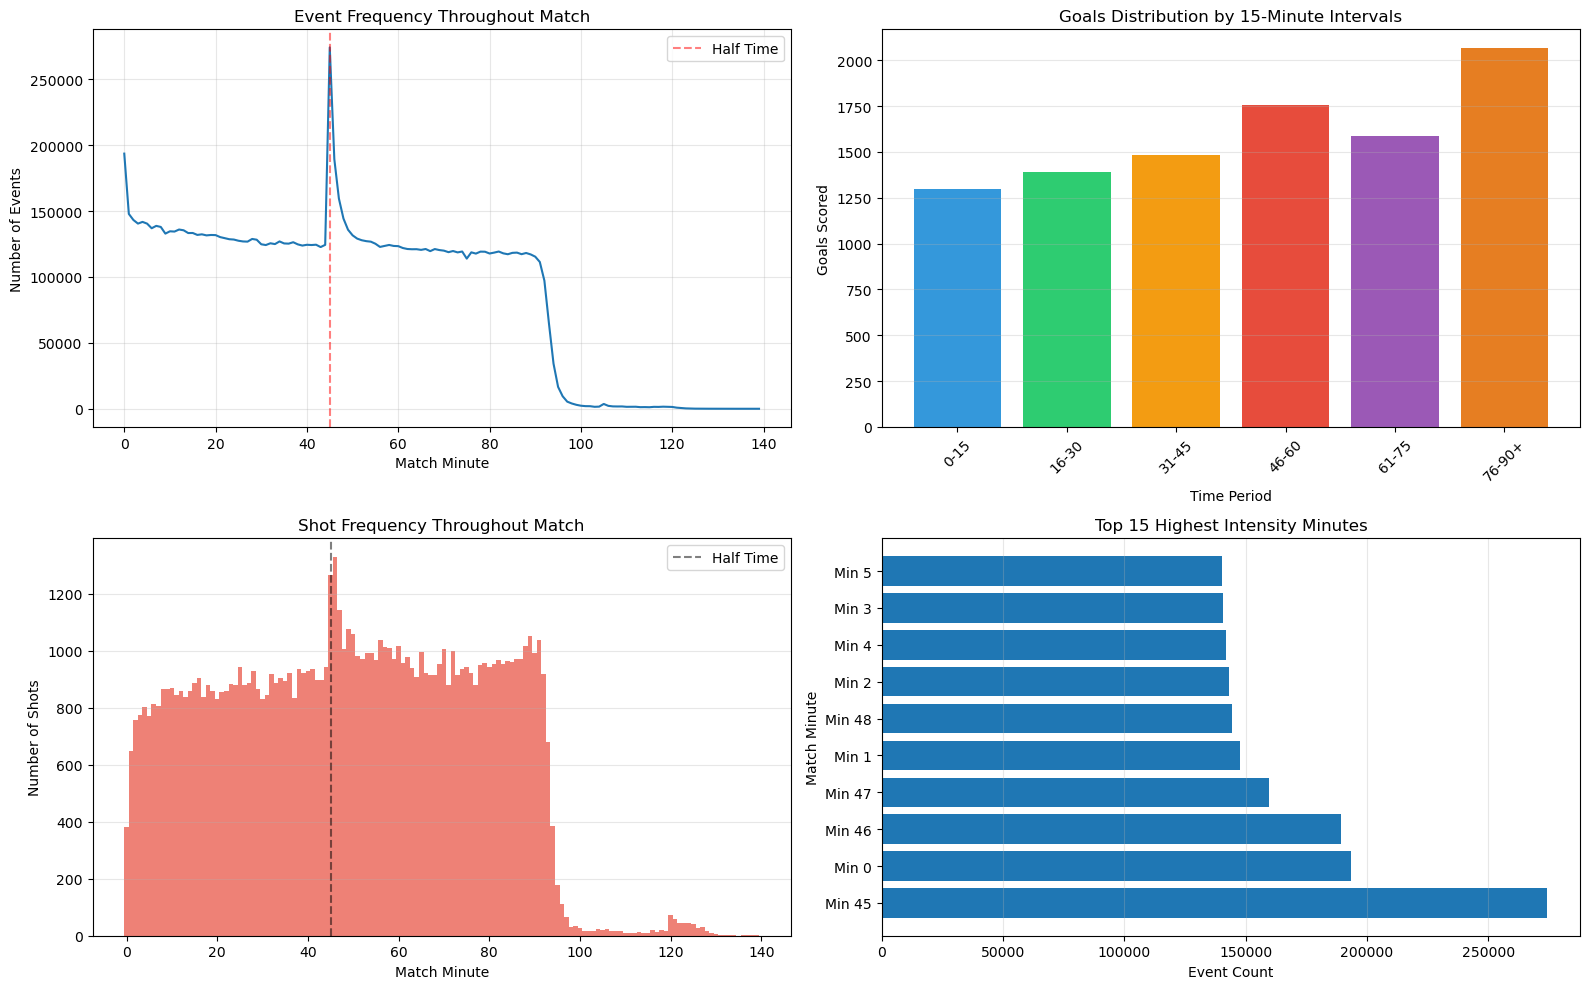

In [15]:
# Visualization: Temporal Patterns

print('='*80)
print('TEMPORAL PATTERN CHARTS')
print('='*80)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Events frequency over time
ax1 = axes[0, 0]
ax1.plot(events_by_minute['minute'], events_by_minute['event_count'], linewidth=1.5)
ax1.axvline(x=45, color='red', linestyle='--', alpha=0.5, label='Half Time')
ax1.set_xlabel('Match Minute')
ax1.set_ylabel('Number of Events')
ax1.set_title('Event Frequency Throughout Match')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Goals by time period
if len(goals) > 0:
    ax2 = axes[0, 1]
    goals_plot = goals_by_period.reindex(['0-15', '16-30', '31-45', '46-60', '61-75', '76-90+'], fill_value=0)
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#e67e22']
    ax2.bar(range(len(goals_plot)), goals_plot.values, color=colors)
    ax2.set_xticks(range(len(goals_plot)))
    ax2.set_xticklabels(goals_plot.index, rotation=45)
    ax2.set_xlabel('Time Period')
    ax2.set_ylabel('Goals Scored')
    ax2.set_title('Goals Distribution by 15-Minute Intervals')
    ax2.grid(axis='y', alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No Goal Data', ha='center', va='center', fontsize=14)
    axes[0, 1].axis('off')

# Plot 3: Shot timing
if len(shots_temporal) > 0:
    ax3 = axes[1, 0]
    shots_by_min = shots_temporal.groupby('minute').size()
    ax3.bar(shots_by_min.index, shots_by_min.values, width=1, color='#e74c3c', alpha=0.7)
    ax3.axvline(x=45, color='black', linestyle='--', alpha=0.5, label='Half Time')
    ax3.set_xlabel('Match Minute')
    ax3.set_ylabel('Number of Shots')
    ax3.set_title('Shot Frequency Throughout Match')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No Shot Data', ha='center', va='center', fontsize=14)
    axes[1, 0].axis('off')

# Plot 4: High-intensity moments
ax4 = axes[1, 1]
top_minutes = high_intensity.head(15)
ax4.barh(range(len(top_minutes)), top_minutes['event_count'].values)
ax4.set_yticks(range(len(top_minutes)))
ax4.set_yticklabels([f"Min {int(m)}" for m in top_minutes['minute'].values])
ax4.set_xlabel('Event Count')
ax4.set_ylabel('Match Minute')
ax4.set_title('Top 15 Highest Intensity Minutes')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

